In [182]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition


## Predicting a Biological Response

Predict a biological response of molecules from their chemical properties  
https://www.kaggle.com/c/bioresponse/data

Каждая строка в этом наборе данных представляет молекулу. Первый столбец содержит экспериментальные данные, описывающие реальную биологическую реакцию; было обнаружено, что молекула вызывает эту реакцию (1) или нет (0). Остальные столбцы представляют молекулярные дескрипторы (от d1 до d1776), это рассчитанные свойства, которые могут отражать некоторые характеристики молекулы, например, размер, форму или элементный состав. Матрица дескрипторов была нормализована.

Activity : target 0 / 1  
D1-D1776 : featuteres - нормализованные

In [183]:
'''
Читаем данные из файла, и сразу смотрим заголовки столбцов (название фич) и первые 5 строк.

'''
dtf = pd.read_csv('../data/20_bioresponse.csv')
dtf.head()


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [184]:
# ТОDO: определите общее количество записей набора данных
len(dtf)

3751

In [185]:
dtf.shape

(3751, 1777)

In [186]:
# ТОDO: определите, имеются ли пропущенные значения
# все 1777 колонок без пропусков
dtf.isnull().any().value_counts()

False    1777
Name: count, dtype: int64

In [187]:
#распределение категорий в Activity 
activity_vc = dtf.value_counts('Activity')
print(activity_vc)

Activity
1    2034
0    1717
Name: count, dtype: int64


чтоб уж совсем было одинаковое количество объектов в каждом классе, удалим часть первых объектов с Activity = 1 

In [188]:
drop_cnt = abs (activity_vc[0] - activity_vc[1])
drop_class = 0
if activity_vc[0]< activity_vc[1] :
    drop_class = 1

print(f'{drop_class = } {drop_cnt = }')

idxDrop = dtf[dtf['Activity'] == drop_class].index[:drop_cnt]

drop_class = 1 drop_cnt = np.int64(317)


In [189]:
dtf.drop(idxDrop, inplace=True,)

проверим ещё раз распределение классов в целевой переменной 

In [190]:
print(dtf.shape)
dtf['Activity'].value_counts()

(3434, 1777)


Activity
0    1717
1    1717
Name: count, dtype: int64

In [191]:
'''
Определяет, является ли столбец числовым или категориальным.
:параметр
     :param dtf: dataframe - входные данные
     :param col:str - имя столбца для анализа
     :param max_cat: num — максимальное количество уникальных значений для распознавания столбца как категориального
:возвращает
     "cat", если столбец является категориальным или "num" в противном случае


Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

In [192]:
# 3751x1777 hitmap слжно будет нарисовать
# к тому же пропусков в  моём наборе данных нет
# для демонстрации построения визулизации возьмём первые 10 признаков
# туда как раз попадут и категориальные 

col_cnt = 10
row_cnt = 10

'''
формируем словарь dic_cols.
Ключи - название фич
Значение - категориальный (cat) или числовой (num)
'''
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns[:col_cnt]}
dic_cols

{'Activity': 'cat',
 'D1': 'num',
 'D2': 'num',
 'D3': 'cat',
 'D4': 'cat',
 'D5': 'num',
 'D6': 'num',
 'D7': 'num',
 'D8': 'num',
 'D9': 'num'}

In [193]:
'''
dtf.isnull() - возвращает датасет, который похож на изначальный датасет dtf, 
но в каждой ячейке вместо значений написано:
 False (если значение есть)
 True  (если в ячейке отсутствует значение)
'''
heatmap = dtf.iloc[:row_cnt,:col_cnt].isnull()
heatmap.shape

(10, 10)

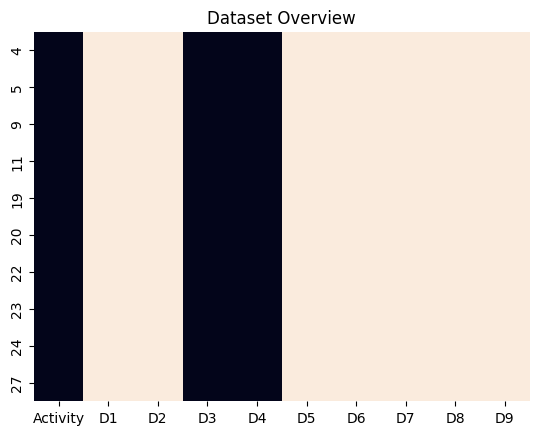

 Categerocial   Numeric   NaN 


In [194]:

'''
А дальше проходим по столбцам, и меняем значения:
 если столбец числовой:
    пишем 0.5, если значение False (то есть оно не нулевое)
    пишем 1,   если значение True

 если столбец категориальный
    пишем 0, если значение False   (то есть оно не нулевое)
    пишем 1,   если значение True

После этого у нас окажется, что значения могут принимать всего три различных значения.
'''
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

'''
Строим heatmap (тепловую карту)
0.5 - если значение есть и оно числовое
0   - если значение есть и оно категориальное
1   - если значения в ячейке нет
'''
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')

plt.show()

'''
Печатаем внизу подобие легенды, раскрашивая так, как нужно.
'''
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

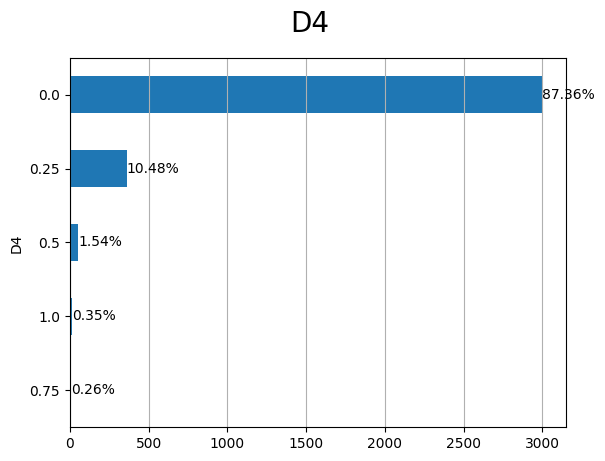

In [195]:
'''
Анализируем, какое количество пингвинов в различных видах (species)
другими словами, мы группируем все объекты по их целевой переменной (species) и просто считаем,
сколько объектов попало в каждую группу
'''

#y = "species"  # вот тут задаем название столбца, по значению в котором и будем группировать
#y ="island"
#в нашем случае для демонстрации возьмём категориальный признак, например, D3
y ="D4"

'''
далее считаем количество объектов с одинаковыми значениями в столбце y: dtf[y].value_counts()
потом сортируем полученное sort_values()
и задаем plot
'''
ax = dtf[y].value_counts().sort_values().plot(kind="barh")

'''
Затем занимаемся тем, что формируем надписи для графика
'''
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)

'''
И наконец-то отрисовываем
'''
plt.show()

/tmp/ipykernel_343624/3566990769.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])#зададим данные для графика
/home/azot/study24/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


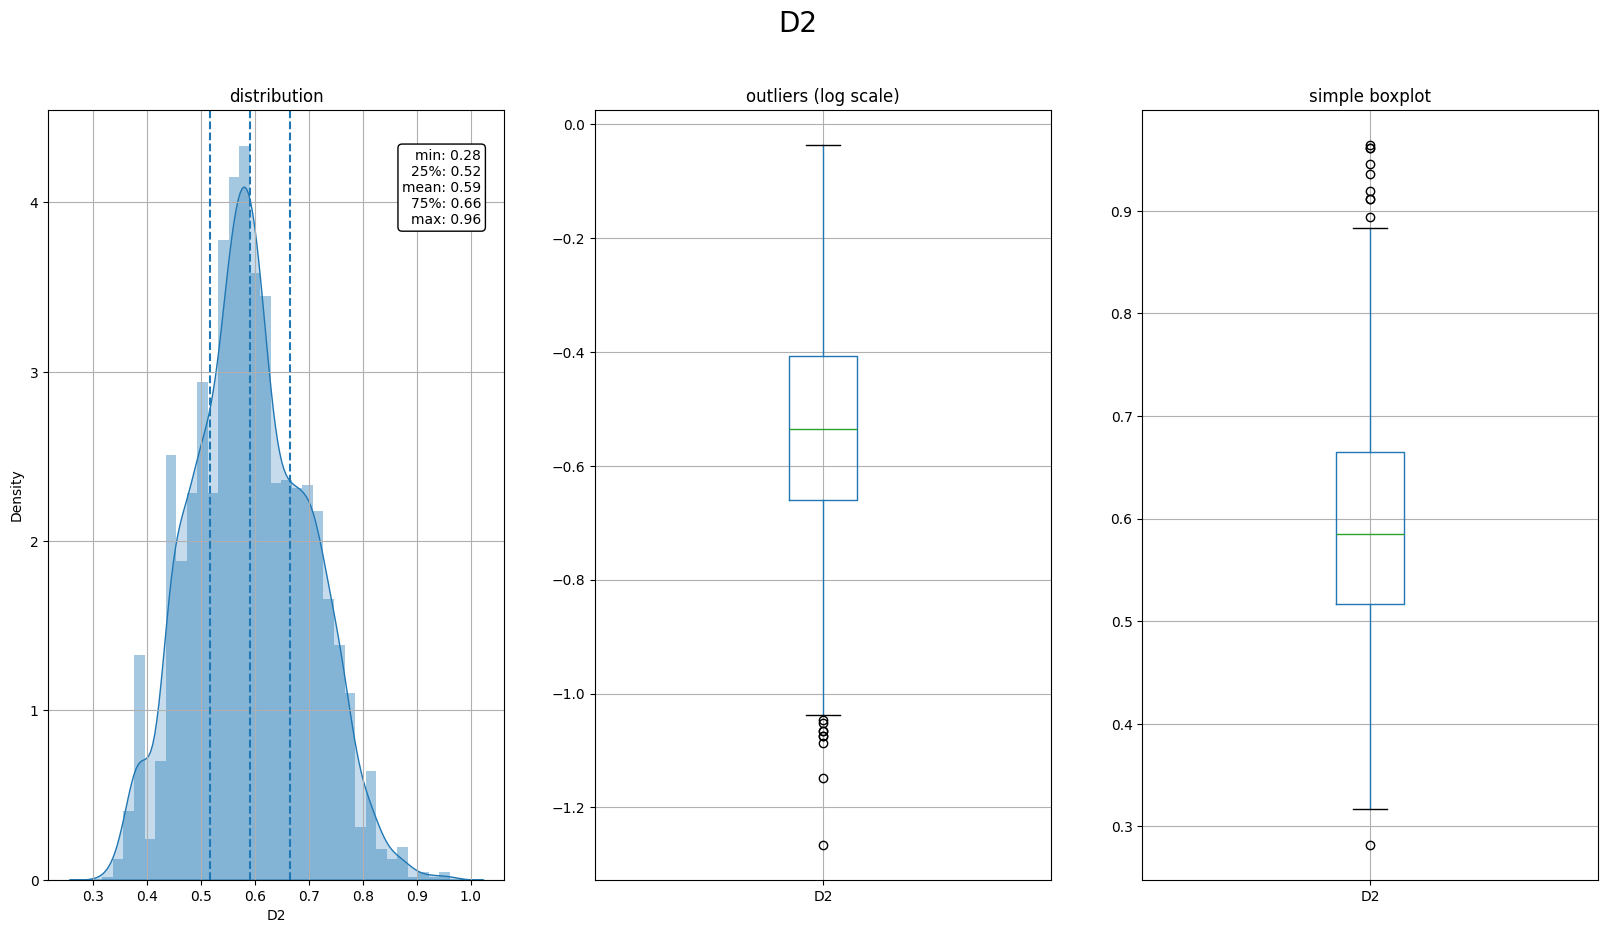

In [196]:
# распределение числового признака D1
# в датасете признаки нормированные, поэтому добавил обычный boxplot (без логарифма)

'''
Используем блочную диаграмму для графического отображения групп данных через их квартили.
Построим целевую пременную "body_mass_g"
'''

x = 'D2'
#x = "body_mass_g"
#x = "culmen_depth_mm"
'''
plt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plt.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.

При использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.

Наличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью fig.savefig('yourfilename.png')).


'''

fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=(20, 10))
fig.suptitle(x, fontsize=20)#задаем заголовок основного рисунка
'''
Пропишем распределение:
'''
### distribution
ax[0].title.set_text('distribution')#задаем название
variable = dtf[x].fillna(dtf[x].mean())#замена отсутствующих значений в датафрейме на средние
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))#вычисляем q-й квантиль заданных данных вдоль указанной оси.
variable = variable[ (variable > breaks[0]) & (variable <
                                               breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])#зададим данные для графика
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
'''
 Формируем надписи для графика
'''
### boxplot

ax[1].title.set_text('outliers (log scale)')#устанавливаем заголовок
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
'''
Отрисовываем
'''

ax[2].title.set_text('simple boxplot')#устанавливаем заголовок
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = tmp_dtf[x]
tmp_dtf.boxplot(column=x, ax=ax[2])

plt.show()

In [197]:
'''
А теперь обернем все, что было в предыдущей ячейке - в функцию для удобства повторного использования.
show_dist
'''

def show_dist(x, dtf, show_log=True):
    '''
    :param x: название столбца
    :param dtf: датасет
    :return: ничего не возвращает
    '''
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = dtf[x].fillna(dtf[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[(variable > breaks[0]) & (variable <
                                                  breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
                 ax=ax[0])  #Запишем чтобы создать горизонтальную гистограмму
    des = dtf[x].describe()


    '''
    Добавим квантильные и средние линии
     '''
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(
        ("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))
    '''
     Формируем надписи для графика
    '''
    ### boxplot
    tmp_dtf = pd.DataFrame(dtf[x])
    if show_log :
        ax[1].title.set_text('outliers (log scale)')  #устанавливаем заголовок
        tmp_dtf[x] = np.log(tmp_dtf[x])
    else :
     ax[1].title.set_text('outliers')  #устанавливаем заголовок
     tmp_dtf[x] = tmp_dtf[x]
    tmp_dtf.boxplot(column=x, ax=ax[1])
    '''
    Отрисовываем
    '''
    plt.show()


/tmp/ipykernel_343624/4095798170.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/home/azot/study24/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


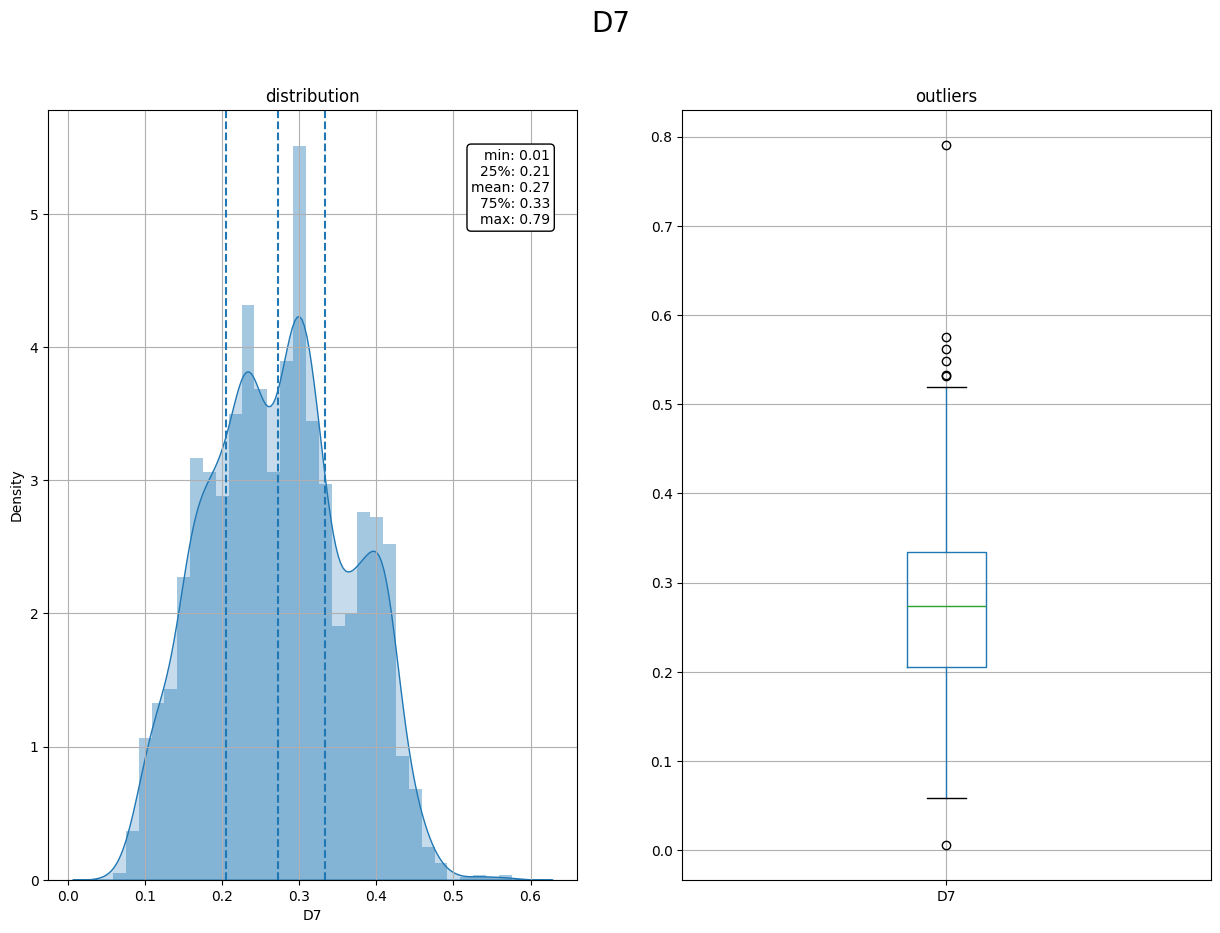

In [198]:
# интервал значений D7 
'''
Проверяем, как работает
'''
show_dist('D7', dtf, show_log = False)

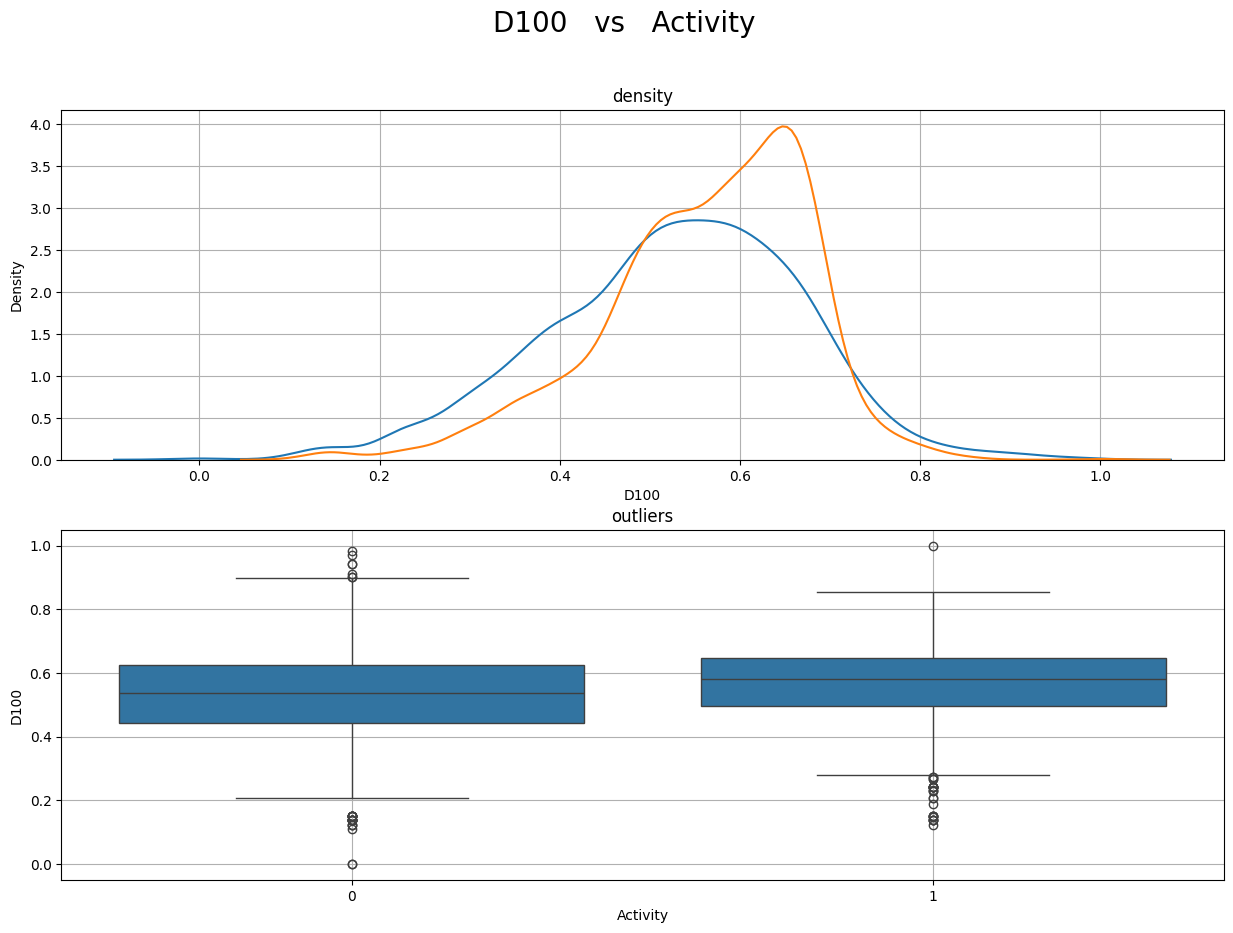

In [199]:
'''
Для того, чтобы понять, обладает ли  "body_mass_g" предсказательной силой для предсказания"species", 
построим график плотности распределений и усиковую диаграмму body_mass_g  для каждого уникального species.

'''

# в нашем случае целевая переменная Class и признак D100
# все числовые признаки первой сотни имеют примерно одинаковые моды в классах 

cat, num = "Activity", "D100"
# распаковываем  кортеж в переменные figи ax.
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))
# получаем объект рисунка и массив подграфиков,где 
# первое число - количество строк,
# второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
fig.suptitle(num+"   vs   "+cat, fontsize=20)
'''
Пропишем распределение:
'''
#print(tmp, type(tmp))
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():  # перебираем все уникальные значения в столбце dtf[cat], cat="species"
    sns.kdeplot(dtf[dtf[cat]==i][num], hue_order=cat,  ax=ax[0], legend=True)#Построим график плотности распределения в столбце num, при условии, что значение в столбце dtf[cat] совпадет с i
ax[0].grid(True)#Настроим линии сетки.

### boxplot
ax[1].title.set_text('outliers')#устанавливаем заголовок
sns.boxplot(x=cat, y=num, data=dtf, ax=ax[1])#Нарисуем блочную диаграмму, чтобы показать распределения по категориям.


ax[1].grid(True)#Настроим линии сетки.
'''
  Отрисовываем
'''

plt.show()

In [200]:
# в нашем наборе данных кодирование категориальных признаков и удаление пропущенных значений
# не требуется
'''
Подготовим структуру словаря из фрейма данных со столбцами
'''
def prep(df):
    df.loc[df.species == 'Adelie', 'species_ind'] = 0
    df.loc[df.species == 'Chinstrap', 'species_ind'] = 1
    df.loc[df.species == 'Gentoo', 'species_ind'] = 2
    df.loc[df.island == 'Biscoe', 'island_ind'] = 0
    df.loc[df.island == 'Dream', 'island_ind'] = 1
    df.loc[df.island == 'Torgersen', 'island_ind'] = 2

    df.loc[df.sex == 'MALE', 'sex_g'] = 0
    df.loc[df.sex == 'FEMALE', 'sex_g'] = 1
    '''
    axis -будут ли удалены строки или столбцы, содержащие пропущенные значения.
    how- удаляется ли строка или столбец из DataFrame, когда у нас есть хотя бы один NA или все NA.
    thresh- количество значений, не относящихся к NA
    subse-Метки вдоль другой оси, которые следует учитывать,
    например, если вы отбрасываете строки, это будет список столбцов для включения.
    inplace-Нужно ли изменять DataFrame,  не создавая новый.
    '''
    df.drop('Unnamed: 0', axis=1, inplace=True)#Удаление указанных меток из строк / столбцов
    emdf = df.dropna(axis=0, how='any', inplace=False)#Удалм пропущенные значения
    return  emdf


In [201]:
'''
    При разделении данных на обучающие и тестовые наборы вы должны следовать одному основному правилу:
        строки в обучающем наборе не должны также появляться в тестовом наборе.
        Это потому, что модель видит целевые значения во время обучения
        и использует их для понимания явления.
        Другими словами, модель уже знает правильный ответ для обучающих наблюдений (.
'''

y_col_name = 'Activity'

## split data , 70% - тренировочная выборка, 30% тестовая выборка
#dtf_tr, dtf_t = model_selection.train_test_split(dtf, test_size=0.3)
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3, random_state=40)

# подготавливаем данные в трейне и тесте одинаково
# dtf_train = prep(dtf_tr)
# dtf_test = prep(dtf_t)

## print info
print("X_train shape:", dtf_train.drop(y_col_name,axis=1).shape, "| X_test shape:",
       dtf_test.drop(y_col_name,axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train[y_col_name]),2), 
      "| y_test mean:", round(np.mean(dtf_test[y_col_name]),2))
print(dtf_train.drop(y_col_name,axis=1).shape[1],
      "features (first 10):", dtf_train.drop(y_col_name,axis=1).columns.to_list()[:10])

X_train shape: (2403, 1776) | X_test shape: (1031, 1776)
y_train mean: 0.5 | y_test mean: 0.49
1776 features (first 10): ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']


In [202]:
# смотрим размер полученной выборки трейне.. 233 столбцов, 10 строк
dtf_train.shape

(2403, 1777)

In [203]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для трейна
# колонка 0 в нашем наборе данных - это целевая переменная Activity
train_x = dtf_train.iloc[:,1:]
train_y = dtf_train[y_col_name]
(train_x.shape, train_y.shape)

((2403, 1776), (2403,))

In [204]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для теста
test_x = dtf_test.iloc[:,1:]
test_y = dtf_test[y_col_name]
(test_x.shape, test_y.shape)

((1031, 1776), (1031,))

In [298]:
# наш набор уже нормирован


# # нормируем значения
# Y = 'species_ind'

# scaler = preprocessing.MinMaxScaler(feature_range=(0,1))#приведем Числовые переменные (Numeric Variable) к диапазону от 0 до 1.
# X = scaler.fit_transform(train_x)#преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1.
# '''
#  X_train - это весь экземпляр с атрибутами,
#  y_train - это метка каждого экземпляра.
# '''
# train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )

train_x_scaled = train_x
train_y_scaled = train_y

test_x_scaled = test_x
test_y_scaled = test_y

train_x_scaled.head()# выводим



,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
3492,0.000000,0.451850,0.05,0.0,0.116629,0.669250,0.300361,0.565443,0.764363,0.273463,...,0,0,0,0,0,0,0,0,0,0
1632,0.033300,0.486480,0.10,0.0,0.135877,0.755176,0.210774,0.517122,0.831410,0.185184,...,1,0,1,0,1,0,0,0,0,1
3547,0.300000,0.763103,0.10,0.5,0.106266,0.669706,0.319260,0.575038,0.722036,0.358978,...,0,0,0,0,1,0,0,0,1,1
1862,0.066700,0.495314,0.00,0.0,0.269519,0.678859,0.243203,0.067800,0.711270,0.221600,...,0,0,0,0,0,0,0,0,0,0
2588,0.166667,0.679315,0.25,0.0,0.151626,0.714680,0.168499,0.458191,0.728254,0.196566,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_343624/4095798170.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/home/azot/study24/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


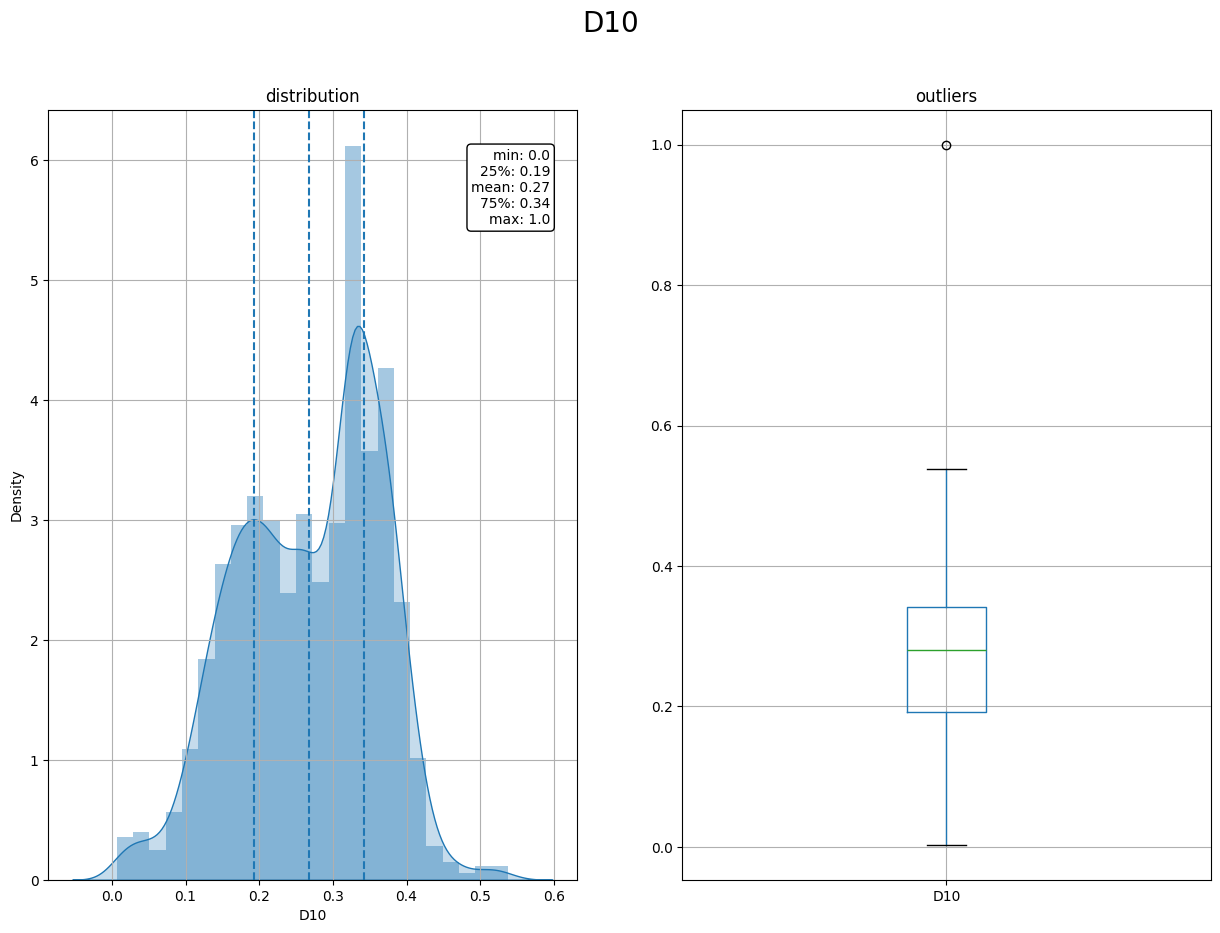

In [206]:
#используем ранее созданную нами функцию для отрисовки графиков
show_dist('D10', train_x_scaled, show_log=False) 

/tmp/ipykernel_343624/4095798170.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/home/azot/study24/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


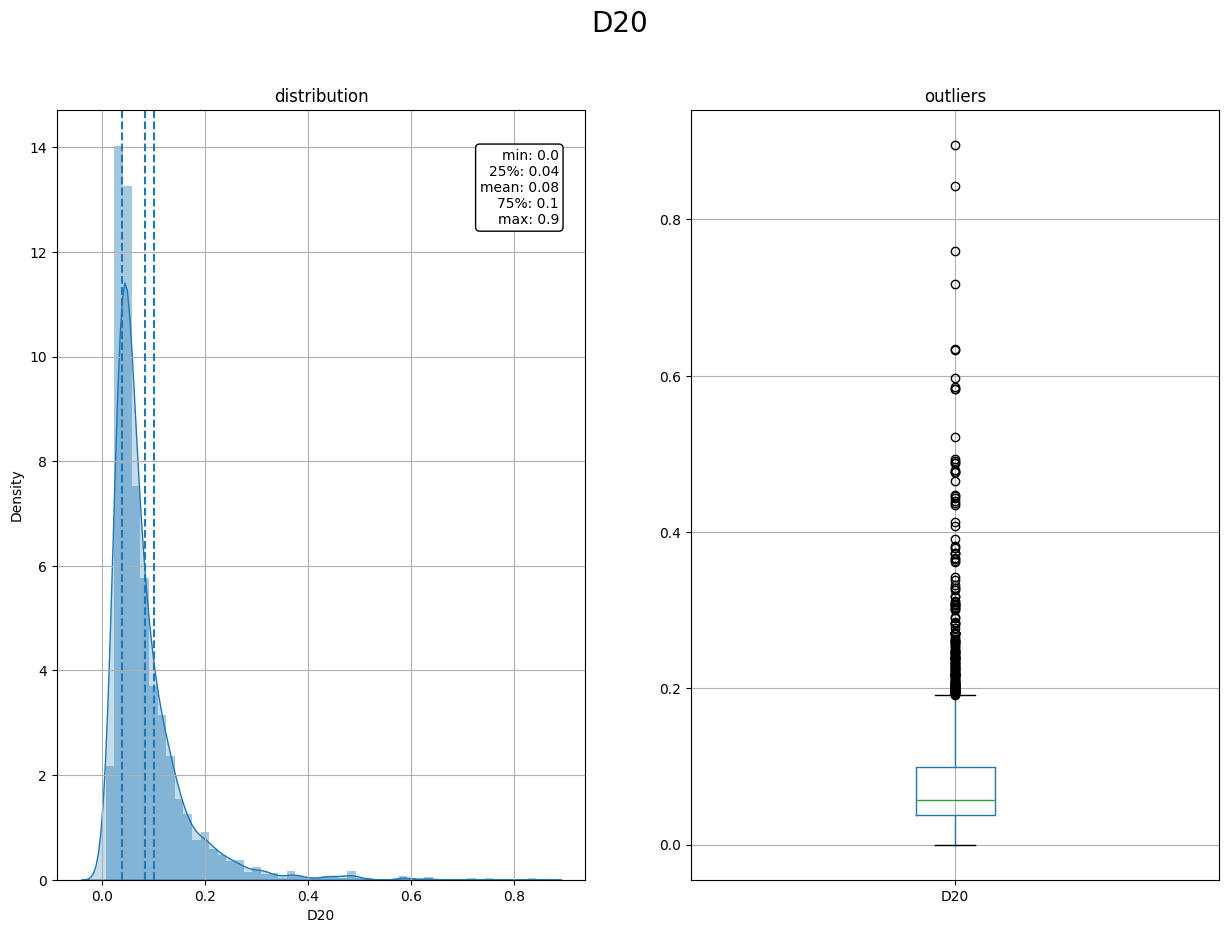

In [207]:
#используем ранее созданную нами функцию для отрисовки графиков
show_dist('D20', train_x_scaled, show_log=False) 

In [208]:
'''
Смотрим, что лежит в X, который результат нормировки train_x
'''
#X

'\nСмотрим, что лежит в X, который результат нормировки train_x\n'

In [209]:
'''
смотрим какие индексы (по-сути номера объектов в основном датасете) остались в трейне
'''
train_x.index


Index([3492, 1632, 3547, 1862, 2588,  256, 2317, 3179, 3500, 2520,
       ...
       3207,  943, 2180, 3657, 1647, 3381, 2530, 2372, 2584, 3715],
      dtype='int64', length=2403)

In [210]:
'''
Метод fit(data) используется для вычисления среднего значения и стандартного отклонения для данной функции, которые будут использоваться в дальнейшем для масштабирования.
Метод transform(data) используется для выполнения масштабирования с использованием среднего значения и стандартного отклонения, рассчитанного с использованием метода .fit().
Метод fit_transform() выполняет как подгонку, так и преобразование.
 X_train - это весь экземпляр с атрибутами,
 y_train - это метка каждого экземпляра.
scaled_x_train - фрейм данных с именами объектов,
scaled_x_test.values - значения, без имен объектов
'''

# X = scaler.fit_transform(test_x)

# test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index )
# test_y_scaled = test_y

'\nМетод fit(data) используется для вычисления среднего значения и стандартного отклонения для данной функции, которые будут использоваться в дальнейшем для масштабирования.\nМетод transform(data) используется для выполнения масштабирования с использованием среднего значения и стандартного отклонения, рассчитанного с использованием метода .fit().\nМетод fit_transform() выполняет как подгонку, так и преобразование.\n X_train - это весь экземпляр с атрибутами,\n y_train - это метка каждого экземпляра.\nscaled_x_train - фрейм данных с именами объектов,\nscaled_x_test.values - значения, без имен объектов\n'

In [211]:
'''
Выбор параметров (фич, features)  — это процесс выбора для обучения модели подмножества параметров из всех параметров датасета.
Это упрощает обучение модели и уменьшает вероятность переобучения (когда модель слишком сильно адаптируется к обучающим данным и плохо работает вне набора train).

Вычислим матрицу корреляции, чтобы увидеть, какие параметры коррелируют друг с другом и целевой переменной:
 '''

#corr_matrix = (dtf.drop("Unnamed: 0", axis=1)).copy()

corr_matrix = dtf.copy()

for col in corr_matrix.columns: #зададим условия для столбцов
 '''
 corr_matrix принимает входное отношение с числовыми столбцами и вычисляет коэффициент корреляции Пирсона между  каждой парой входных столбцов и возвращает матрицу корреляции в формате триплета.
 То есть каждая парная корреляция идентифицируется тремя возвращаемыми столбцами:
 имя первой переменной,  имя второй переменной и значение корреляции пары.
 Функция также возвращает два дополнительных столбца: number_of_ignored_input_rows и number_of_processed_input_rows.
 Значение четвертого/пятого столбца указывает количество строк из ввода, которые игнорируются/используются  для вычисления соответствующего значения корреляции.
 Любая входная пара с NULL, Inf или NaN игнорируется.

Корреляционная матрица симметрична со значением 1 на всех диагональных элементах
 '''

if corr_matrix[col].dtype == "O":
        corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)

corr_matrix

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
Activity,1.000000,-0.096324,0.102983,0.168792,-0.043956,-0.151229,-0.105687,0.131631,0.169583,-0.076672,...,0.001853,0.077697,0.030397,0.008243,0.036831,0.009197,0.024734,0.002748,0.048425,0.017155
D1,-0.096324,1.000000,0.265082,0.332671,0.261895,-0.083817,0.361877,-0.422391,-0.104593,0.186881,...,0.251512,0.200935,0.202339,0.220374,0.221893,0.216310,0.101303,0.172555,0.221548,0.200932
D2,0.102983,0.265082,1.000000,0.437277,0.353473,0.210891,-0.140984,-0.025684,0.156863,-0.355558,...,0.016678,0.071843,0.018919,0.041280,0.044308,0.020380,0.024882,0.038318,0.031441,0.076066
D3,0.168792,0.332671,0.437277,1.000000,0.191176,-0.129812,-0.036389,-0.208876,0.078589,-0.140240,...,0.053627,0.139263,0.040935,0.102839,0.125945,0.026259,0.045098,0.136425,0.016299,0.196793
D4,-0.043956,0.261895,0.353473,0.191176,1.000000,-0.021543,-0.001813,-0.060357,0.071426,-0.034327,...,-0.006722,0.077772,-0.001330,0.034926,0.043225,-0.004020,0.016686,0.028371,0.010943,0.074939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D1772,0.009197,0.216310,0.020380,0.026259,-0.004020,-0.116895,0.158406,-0.129443,-0.005237,0.134840,...,0.579133,0.281665,0.544992,0.567163,0.275306,1.000000,0.246579,0.116389,0.414043,0.257638
D1773,0.024734,0.101303,0.024882,0.045098,0.016686,-0.096378,0.113204,-0.088127,0.023528,0.090890,...,0.419941,0.247561,0.250472,0.276257,0.242001,0.246579,1.000000,0.299739,0.322664,0.312760
D1774,0.002748,0.172555,0.038318,0.136425,0.028371,-0.102358,0.131057,-0.096555,0.022066,0.093586,...,0.419941,0.294867,0.178755,0.334600,0.149311,0.116389,0.299739,1.000000,0.302794,0.393708
D1775,0.048425,0.221548,0.031441,0.016299,0.010943,-0.132669,0.134089,-0.088983,0.022387,0.109823,...,0.539991,0.345805,0.386478,0.456427,0.355834,0.414043,0.322664,0.302794,1.000000,0.212870


In [212]:
# корреляцию всех 1776 признаков на heatmap не показать 
# возьмём признаки наиболее коррелирующие с Activity
# pd.Series c .name=Activity
corr_col = corr_matrix['Activity'].copy()
corr_col.name = 'corr'
corr_col = corr_col.to_frame()
corr_col['corr_abs'] = corr_col.abs()
corr_col.sort_values('corr_abs',ascending=False,inplace=True)
corr_col.head(10)
#.sort_values(ascending=False)

,corr,corr_abs
Activity,1.000000,1.000000
D27,0.474666,0.474666
D469,0.273839,0.273839
D182,0.240877,0.240877
D217,-0.237185,0.237185
D659,0.229854,0.229854
D747,0.227917,0.227917
D87,-0.226039,0.226039
D209,0.216398,0.216398
D607,0.216088,0.216088


In [213]:
corr10_matrix = corr_matrix.loc[corr_col.index[:10],corr_col.index[:10]]

Text(0.5, 1.0, 'pearson correlation')

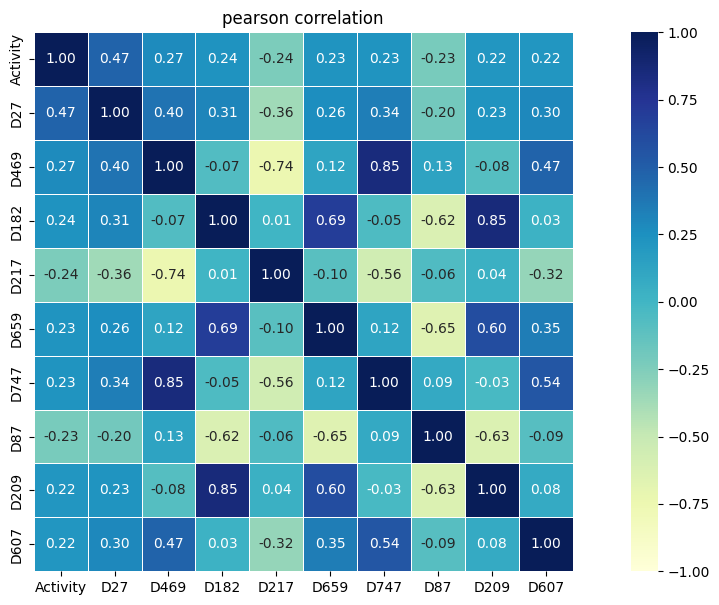

In [214]:

plt.figure(figsize=(15,7),dpi=100)

'''
Основная цель Seaborn heatmap — визуализировать correlation matrix  для feature selection для решения задач.
Vmin и vmax устанавливают нижнюю и верхнюю границы цветовой полосы

Чтобы изменить цвет heatmap , используют параметр cmap (colormap) sns.heatmap

Каждая ячейка sns.heatmap отображается по номеру, и если нужно  показать этот номер в ячейке,
тогда используется sns.heatmap() annot (annotation) Если записать « True » в annot ,
это значение будет отображаться в каждой ячейке .

fmt позволяет добавлять строковые (текстовые) значения в ячейку.

Cbar по умолчанию имеет логическое значение True, если поменять его намFalse, то цветная полоса скрывается.
'''


sns.heatmap(corr10_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("pearson correlation")

In [215]:
# с параметрами по умолчанию важность признаков сильно отличается от того, что показывает
# корреляционная матрица (предыдущая визуализация)
# если не ограничивать глубину деревьев - получаем все характеристики 1
# попробуем два варианта оценки важности признаков

# model_a - без ограничения по глубине деревьев
# model_b - n_estimators=2000, max_depth=5

'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist()# имена столбцов в data.
## Importance
model_a = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=40)
model_a.fit(X,y)

model_b = ensemble.RandomForestClassifier(n_estimators=300, max_depth=5,
                                        criterion="entropy", random_state=40)
model_b.fit(X,y)

#это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
def get_impotance(model):
    importances = model.feature_importances_ 
    dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                    "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                        ascending=False)
    dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
    dtf_importances = dtf_importances.set_index("VARIABLE")
    return dtf_importances

dtf_importances_a = get_impotance(model_a)
dtf_importances_b = get_impotance(model_b)

predicted_a = model_a.predict(X)
print('model_a:')
print(metrics.classification_report(y, predicted_a))

predicted_b = model_b.predict(X)
print('model_b:')
print(metrics.classification_report(y, predicted_b))

model_a:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1195
           1       1.00      1.00      1.00      1208

    accuracy                           1.00      2403
   macro avg       1.00      1.00      1.00      2403
weighted avg       1.00      1.00      1.00      2403

model_b:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1195
           1       0.82      0.74      0.78      1208

    accuracy                           0.78      2403
   macro avg       0.79      0.79      0.78      2403
weighted avg       0.79      0.78      0.78      2403



In [229]:
#модель A: как и в матрице корреляций лидер D27, и ниже D469, остальные признаки не такие как в матрице корреляций
print('первая десятка важных признаков по матрице корреляции:')
print(corr10_matrix.columns.to_list())

print('коммуляттивная сумма model_a:')
print('200:',dtf_importances_a.iloc[200,1])
print('500:',dtf_importances_a.iloc[500,1])
print('800:',dtf_importances_a.iloc[800,1])
dtf_importances_a.head(10)

первая десятка важных признаков по матрице корреляции:
['Activity', 'D27', 'D469', 'D182', 'D217', 'D659', 'D747', 'D87', 'D209', 'D607']
коммуляттивная сумма model_a:
200: 0.6751391397261697
500: 0.8653776437002115
800: 0.9492089885669258


,IMPORTANCE,cumsum
VARIABLE,,
D27,0.020458,0.020458
D106,0.009434,0.029892
D14,0.008259,0.038151
D469,0.007813,0.045964
D66,0.007698,0.053662
D84,0.007440,0.061102
D10,0.007427,0.068529
D7,0.007312,0.075841
D16,0.007184,0.083026


In [231]:
#model_b: первые два признака совпадают с теми, что даёт корреалиционная матрица. 
# и ещё два признака (D182, D217) входят в десятку 
#коммулятивная сумма растёт быстрее
print('первая десятка важных признаков по матрице корреляции:')
print(corr10_matrix.columns.to_list())

print('коммуляттивная сумма model_a')
print('200:',dtf_importances_b.iloc[200,1])
print('500:',dtf_importances_b.iloc[500,1])
print('800:',dtf_importances_b.iloc[800,1])
dtf_importances_b.head(10)

первая десятка важных признаков по матрице корреляции:
['Activity', 'D27', 'D469', 'D182', 'D217', 'D659', 'D747', 'D87', 'D209', 'D607']
коммуляттивная сумма model_a
200: 0.7906101646600536
500: 0.9230127884927761
800: 0.9745303096025545


,IMPORTANCE,cumsum
VARIABLE,,
D27,0.048188,0.048188
D469,0.025269,0.073456
D66,0.017373,0.090829
D187,0.016638,0.107467
D78,0.013106,0.120573
D217,0.013088,0.133661
D106,0.012603,0.146264
D747,0.012038,0.158302
D182,0.011576,0.169878


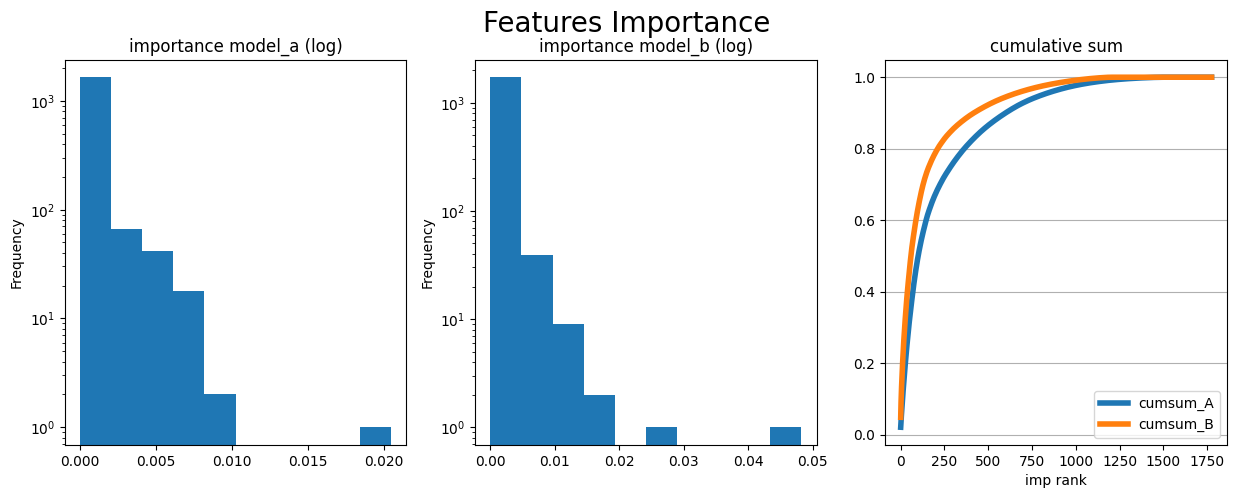

In [288]:
# признаков много - на визуализации будем ориентироваться по рангу (порядковому номеру) важности 
# построим гистограмму
a=dtf_importances_a.reset_index()
b=dtf_importances_b.reset_index()
join_importances = a.join(b,lsuffix='_A',rsuffix='_B')

## Plot
'''
 Формируем надписи для графика

 ticks : подобный массиву, содержащий список местоположений xtick. Передача пустого списка удаляет все xticks. (По желанию)
labels : подобный массиву, содержащий метки для размещения в заданных местах тиков. Этот аргумент может быть передан только в том случае, если также переданы тики. (По желанию)
kwargs : текстовые свойства, которые можно использовать для управления внешним видом меток.
Функция Matplotlib xticks() возвращает:
locs: список местоположений xtick.
labels: список текстовых объектов xlabel
plt.grid - Настройка линий сетки.
axis - Ось, к которой применяются изменения.


'''
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False,figsize=(15,5),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('importance model_a (log)')# подпишем график
join_importances['IMPORTANCE_A'].plot(
     kind="hist", legend=False ,ax=ax[0], logy=True )

ax[1].title.set_text('importance model_b (log)')# подпишем график
join_importances['IMPORTANCE_B'].plot(
     kind="hist", legend=False ,ax=ax[1], logy=True)

# dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
#     kind="barh", legend=False, ax=ax[0]).grid(axis="x")
# ax[0].set(ylabel="")
# ax[1].title.set_text('cumulative')# подпишем график
# dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
#                                  legend=False, ax=ax[1])
# ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
#           xticklabels=dtf_importances.index)
# plt.xticks(rotation=70)
# plt.grid(axis='both')#Настроим линии сетки.

ax[2].set_title('cumulative sum')
join_importances[['cumsum_A','cumsum_B']].plot(
    kind="line", linewidth=4,
    ax=ax[2],xlabel='imp rank'
    ).grid(axis='y')

'''
Отрисовываем
'''
plt.show()

для обеих моделей определения важных признаков есть большой хвост признаков с почти нулевой важностью  
оставим 90% признаков  
посмотрим на хвост менее важных признаков

In [293]:
join_importances[join_importances['cumsum_B']>=0.90]

,VARIABLE_A,IMPORTANCE_A,cumsum_A,VARIABLE_B,IMPORTANCE_B,cumsum_B
418,D237,0.000493,0.829224,D144,0.000309,0.900240
419,D1067,0.000491,0.829715,D974,0.000307,0.900547
420,D1173,0.000491,0.830206,D518,0.000306,0.900853
421,D749,0.000491,0.830697,D1085,0.000305,0.901158
422,D133,0.000490,0.831186,D1384,0.000305,0.901463
...,...,...,...,...,...,...
1771,D467,0.000000,1.000000,D397,0.000000,1.000000
1772,D1239,0.000000,1.000000,D400,0.000000,1.000000
1773,D507,0.000000,1.000000,D1287,0.000000,1.000000
1774,D465,0.000000,1.000000,D484,0.000000,1.000000


In [299]:
'''
Проектирование, обучение, тестирование и оценка модели машинного обучения:
'''
model_columns = join_importances[join_importances['cumsum_B']<0.9]['VARIABLE_B']

X_train = train_x_scaled[model_columns]
y_train = train_y_scaled

X_test = test_x_scaled[model_columns]
y_test = test_y_scaled

X_train.head()

,D27,D469,D66,D187,D78,D217,D106,D747,D182,D660,...,D889,D690,D1163,D1049,D609,D1094,D120,D1109,D1006,D890
3492,0,0.000000,0.140956,0.836962,0.0676,0.539308,0.183149,0.000,0.235648,0.171429,...,0.0,0.0,1,0,0.00,0,0.0,1,1,0.0
1632,0,0.000000,0.027100,0.836962,0.0676,0.539308,0.182791,0.125,0.094300,0.085700,...,0.0,0.0,1,0,0.25,0,0.0,1,0,0.0
3547,0,0.000000,0.036700,0.836962,0.0405,0.539308,0.491848,0.125,0.111647,0.057100,...,0.0,0.0,1,0,0.00,1,0.0,1,1,0.0
1862,0,0.000000,0.000000,0.836962,0.0000,0.539308,0.139953,0.000,0.094300,0.000000,...,0.0,0.0,0,0,0.00,0,0.0,0,0,0.0
2588,1,0.333333,0.054200,0.744500,0.0135,0.278043,0.264162,0.375,0.094300,0.114286,...,0.0,0.0,0,0,0.00,1,0.0,1,0,0.0


In [305]:
'''
Будем использовать GradientBoostingClassifier - градиентный бустинг. Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений.
 Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную. Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом,
 что каждая последующая модель сводит ошибку предыдущей к минимуму.
 Оценивать качество предсказаний будем по RandomizedSearchCV
'''

## call model
model = ensemble.GradientBoostingClassifier(random_state=40)
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05],     #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],  #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],    #максимальная глубина дерева
             'min_samples_split':[2,4,6],    #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],     #минимальное количество выборок для формирования листа
             'max_features':[2,4,8],     #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       #образцы, которые будут использоваться для подгонки индивидуального базового файла
## random search(Рандомизированный поиск по гиперпараметрам.)
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy",
                                                   random_state=40
                                                   ).fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # здесь теперь хранятся параметры, при которых были получены наилучшие метрики на трейне

Best Model parameters: {'subsample': 1, 'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 4, 'learning_rate': 0.1}
Best Model mean accuracy: 0.7819308731808732


In [316]:
'''
X_train - это тренировочный датасет
y_train - это целевая переменная для каждого объекта в X_train.
'''
## train
## заполняем модель данным из трайн датасетов
model.fit(X_train, y_train)

## test
predicted_prob = model.predict_proba(X_test) #прогнозирование
'''
Функция Predict() принимает только один аргумент , который представляет собой test датасет.
'''
predicted = model.predict(X_test).astype('int32')

In [317]:
'''
смотрим, что получили
А получили мы для каждого объекта - вектор вероятностей отнесения этого объекта к классам species
'''
predicted_prob

array([[0.0601181 , 0.9398819 ],
       [0.92508079, 0.07491921],
       [0.03302643, 0.96697357],
       ...,
       [0.87903153, 0.12096847],
       [0.96106666, 0.03893334],
       [0.94917327, 0.05082673]])

In [318]:
predicted

array([1, 0, 1, ..., 0, 0, 0], dtype=int32)

In [319]:
# а это истинное значение, кто к какому классу относится
y_test.astype('int32') #astype -  позволяет преобразовывать тип данных существующего столбца данных в набор данны

910     1
2779    0
2800    1
3481    0
921     0
       ..
2272    1
3488    0
3558    0
3742    0
2494    0
Name: Activity, Length: 1031, dtype: int32

In [321]:
# бинарная класификация - взял вероятность класса 1
## Accuray e AUC
'''
Теперь смотрим метрики.
НА ТЕСТОВОМ ДАТАСЕТЕ
'''
accuracy = metrics.accuracy_score(y_test, predicted)#Оценим точность классификации.

auc = metrics.roc_auc_score(y_test, predicted_prob[:,1],  
                #multi_class='',
                average= "weighted") #возвращаем долю правильно классифицированных выборок.
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
'''
Получим результат
'''

## Precision e Recall
recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.8
Auc: 0.87
Recall (all 1s predicted right): 0.8
Precision (confidence when predicting a 1): 0.8
Detail:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       522
           1       0.79      0.82      0.80       509

    accuracy                           0.80      1031
   macro avg       0.80      0.80      0.80      1031
weighted avg       0.80      0.80      0.80      1031



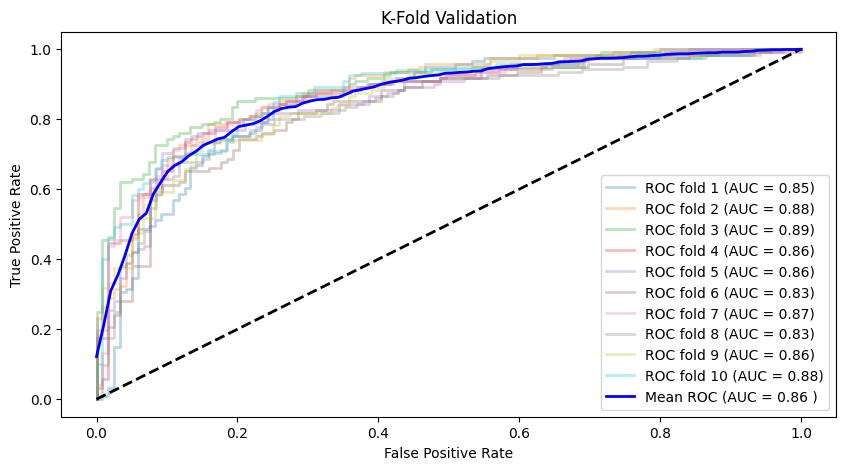

In [322]:
'''
Строим ROC кривые
'''
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    '''
iloc - позволяет получить определенное значение, принадлежащее к строке и столбцу,
используя указанные значения индекса
X_train - это весь экземпляр с атрибутами,
y_train - это метка каждого экземпляра.
train_selected_test - Разделяет массивы / матрицы на случайные тестовые подмножества.

'''
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
'''
Получим результат
'''
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
'''
построим график

'''
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

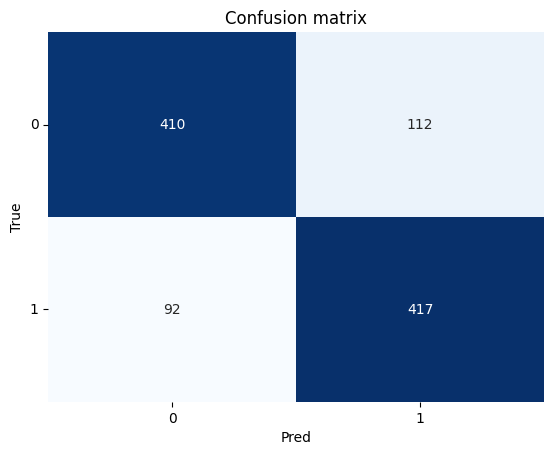

In [323]:
'''
Confusion matrix (Мультиклассовый)
'''

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
'''
построим график

'''

plt.show()

In [72]:
'''
Вспомогательная функция для построения confusion matrix для каждого класса
'''
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

In [324]:
# у на бинарная класификация
'''
Confusion matrix (для каждого класса по отдельности)
'''

# # classes = np.unique(y_test).astype(int)
# # lbs = [1,0]
'''
plt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plt.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.

При использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.

Наличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью fig.savefig('yourfilename.png')).
plt.grid - Настройка линий сетки.

'''
# # fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5),dpi=100)

# # for class_i in classes:
# #     y_one_class = compute_class(y_test,class_i)
# #     predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
# #     cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
# #     sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
# #     ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
# #     ax[class_i].set_xticklabels(labels=lbs, rotation=0)
# #     ax[class_i].set_yticklabels(labels=lbs, rotation=0)

# # plt.show()

"\nplt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.\nplt.subplots() возвращает кортеж с двумя элементами.\n1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.\n\nПри использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.\n\nНаличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже\n(например, с помощью fig.savefig('yourfilename.png')).\nplt.grid - Настройка линий сетки.\n\n"

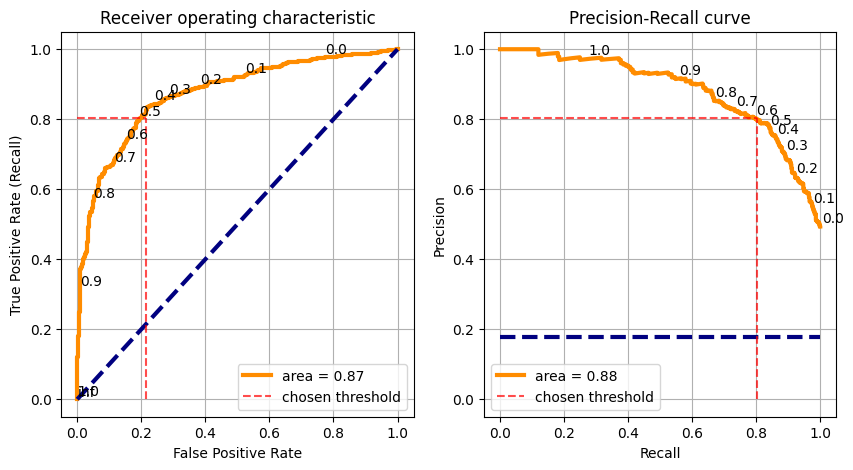

In [325]:
'''
Еще ROC кривые
'''

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)
'''

## plot ROC curve
построим кривую ROC

'''
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
## annotate ROC thresholds
'''
найдем пороговые значения ROC
'''

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
## plot P-R curve
'''
плстроим привую P-R
'''

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
'''
пороговые значения P-R
'''
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

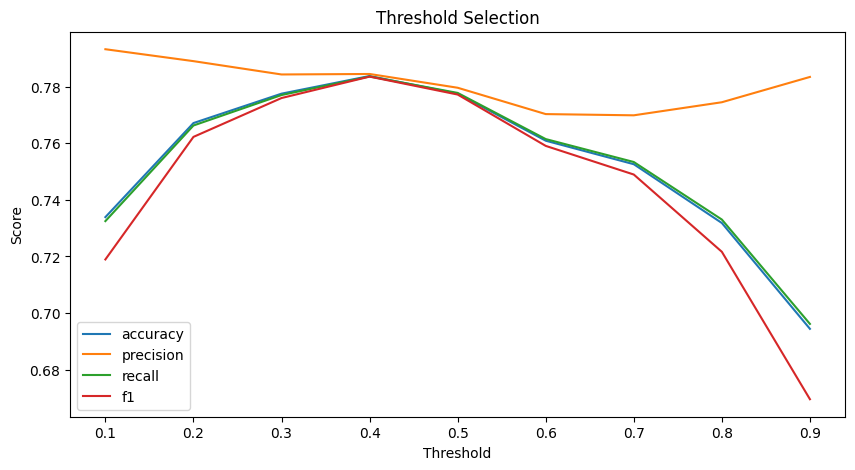

In [326]:
## calculate scores for different thresholds
'''
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1
'''
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax)
'''
отрисовываем
'''

plt.show()